# Preprocessing, Outliers, Categorical data. The stories of PCA you might not find in every textbook.
## Part II-1: Scalers, meet outliers

# Intro (of the series)
Welcome to our journey! We would like to explore the combinasion of scaling data and the PCA, to see how we can better prepare data for machine learning tasks whenever we come across a new dataset.  The journey is composed by three parts:

**Part I**: Rescaling data before applying the PCA. As you've already known, PCA is sensible to the scale of a dataset, hence getting each feature to a reasonable scale is crucial to PCA.  In this part, we are going to see how different scalers can effect the PCA results.

**Part II (this blog)**: Limits of our proposed combinasion. How the scalers react to outliers? What happens if we are to apply PCA naively onto dataset containing categorical features? Can some of the Sklearn-available scalers help to process categorical features to make them consistent with PCA's mechanism? This part will be have two sub parts, each discussing one of the blocks.

**Part III**: PCA as feature engineering for (semi-)supervised learning 

# Part II-1:  Scalers, meet outliers

## Outline of this post

 0. First glance at the augmented dataset
 1. Tests applied on the augmented dataset
 2. Summary

Continuing our journey through the scaler + PCA combination, we arrive now at the station II. This time we are going to challenge these tools with some commonly encountered obstacles in real life datasets, like outliers and categorical variables.

There is rich theory behind the outliers treatment, going into details of the science is not our main point here. We are going to add several synthetic outliers to our wine dataset, and show how each scaler in our tool kit will react with them.

We will then generate some categorical data to challenge PCA. From its mathematical mechanism, you might see that PCA is not suitable for categorical data. Yet what happens if we are to apply it anyway? If the results turn out to be catastrophe, can scalers come to rescue?

This post is a sub section of the part II of our series about scalers and PCA, we will be testing the scalers with synthetic outliers.

As usual, let's get prepared by importing Python packages and defining our helper functions.

In [1]:
# load packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# customer palette for visulization color code
customer_palette = sns.color_palette('Set1', 3)
customer_palette.append(sns.xkcd_palette(['greyish'])[0])

plt.rc('figure', facecolor='w')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,QuantileTransformer,RobustScaler,Normalizer,MaxAbsScaler,MinMaxScaler,PowerTransformer
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, v_measure_score


RANDOM_STATE = 2020

In [2]:
print(sns.__version__)
# print(sklearn.__version__)
print(pd.__version__)
'''
0.10.1
1.0.3
'''

0.10.1
1.0.3


'\n0.10.1\n1.0.3\n'

In [3]:
def transformer_bundle(X_train):

    transformer_dict = {'StandardScaler': StandardScaler(), 
                        'QuantileTransformer':QuantileTransformer(), 
                        'RobustScaler':RobustScaler(), 
                        'Normalizer':Normalizer(), 
                        'MaxAbsScaler':MaxAbsScaler(), 
                        'MinMaxScaler':MinMaxScaler(), 
                        'PowerTransformer':PowerTransformer()}

    X_train_trans_dict = {trs:transformer_dict[trs].fit_transform(X_train) for trs in transformer_dict.keys()} 
    X_train_trans_dict['NoTransformer'] = X_train.values
    
    X_train_pca_dict = {trs:PCA().fit_transform(X_train_trans_dict[trs]) for trs in transformer_dict.keys()}
    X_train_pca_dict['NoTransformer'] = PCA().fit_transform(X_train)
    
    return X_train_trans_dict, X_train_pca_dict 

In [4]:
def trans_heat_plot(X_trans_dict, y_axis_labels):
    nrows = len(X_trans_dict.keys())//2
    ncols = 2
    fig,ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=(ncols*6,nrows*3))
    for i in range(len(X_trans_dict.keys())):
        # the fancy modulo is just to make the "no transformation" come first...
        ind = (i-1)%len(X_trans_dict)
        trs = list(X_trans_dict.keys())[ind]
        X = X_trans_dict[trs]
        
        y_axis_labels = df_features.columns
        
        this_ax = ax[i//2,i%2]
        covmtrx = (np.cov(X.T))
        mask = np.triu(covmtrx,1)
        sns.heatmap(covmtrx, 
                    square=True,
                    mask = mask,
                    yticklabels=y_axis_labels,
                    center= 0,
                    cmap=(sns.color_palette('RdBu_r',256)),
                    ax=this_ax,
           )
        this_ax.set_title(trs,loc='left', fontsize='x-large')
        this_ax.set_xticklabels(this_ax.get_xticklabels(), rotation=0)
        
        
    plt.tight_layout()        
    plt.show()

In [5]:
# trans_heat_plot(X_trans_dict_o, y_axis_labels=df_features.columns)

In [6]:
def pca_scatter_plot(X_pca_dict, y, highlight_list=None):
    y = np.array(y)
    labels=['\nlabel few missing', '\nlabel half missing', '\nlabel all missing']
#     fig = plt.figure(figsize=(4*3,3*8), )
#     G = plt.GridSpec(nrows=len(X_pca_dict.keys()), ncols=3)
    fig, axes = plt.subplots(nrows=len(X_pca_dict.keys()), ncols=3, figsize=(4*3,3*len(X_pca_dict.keys())), sharey='row')
    for i in range(len(X_pca_dict.keys())):
        # the fancy modulo is just to make the "no transformation" come first...
        ind = (i-1)%len(X_pca_dict)
        trs = list(X_pca_dict.keys())[ind]
        X = X_pca_dict[trs]
        
        # if there are some dots to be highlighted..        
        if highlight_list is not None:
            style_list = np.array(['original']*X.shape[0])
            style_list[highlight_list] = 'syn_outliers'
        else:
            style_list=None
            
        for j in range(3):
#             this_ax = fig.add_subplot(G[i, j], sharey='row')
            this_ax = axes[i,j]
            # plot the first 2 components
            sns.scatterplot(data=None, x=X[:,0], y=X[:,1], 
                            hue=y[:,j], hue_order=[0,1,2,-1], 
                            style=style_list, 
                            alpha=0.6, palette=customer_palette, ax=this_ax)
            
            
            # set axis labels and title
            this_ax.set_xlabel('First component')
            this_ax.set_ylabel('Second component')
            this_ax.set_title(trs+labels[j], loc='left', fontsize='large')
#             this_ax.legend(loc=2)
            if j==2:
                this_ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
            else:
                this_ax.get_legend().remove()
    plt.tight_layout(pad=0.5, )
    plt.show()

In [7]:
# pca_scatter_plot(X_pca_dict_o, y_train_o.iloc[:,1:], highlight_list=np.arange(-10,0))

In [8]:
def pca_cluster_contour_plot(X_pca_dict, labels, kmeans):
#     fig, axes = plt.subplots(nrows=len(X_pca_dict.keys()), ncols=1,figsize=(12,8*8))
    fig, axes = plt.subplots(nrows=len(X_pca_dict.keys()), ncols=1,figsize=(8*1,6*len(X_pca_dict.keys())))
    for i in range(len(X_pca_dict.keys())):
        # the fancy modulo is just to make the "no transformation" come first...
        ind = (i-1)%len(X_pca_dict)
        trs = list(X_pca_dict.keys())[ind]
        X = X_pca_dict[trs]

        pred = kmeans.fit_predict(X[:,:2])    
        
        # relabel based on ground truth (a bit head scratching though. we need to use 
#         mode() while prevent repeat, and start with larget count)
        df_tmp = pd.concat([pd.DataFrame(X), labels.target_original, pd.DataFrame({'pred':pred})],axis = 1)
        target_list = []
#         for label in df_tmp.pred.unique():
#             print(df_tmp.pred.value_counts().index)
        for label in df_tmp.pred.value_counts().index:
            if not df_tmp[df_tmp.pred==label].target_original.mode().values[0] in target_list:
                target_list.append(df_tmp[df_tmp.pred==label].target_original.mode().values[0])
            else:
#                 target_list.append('Re'+str(int(df_tmp[df_tmp.pred==label].target_original.mode().values[0])))
                target_list.append(1000+df_tmp[df_tmp.pred==label].target_original.mode().values[0])

    
        df_link = pd.DataFrame({'pred': df_tmp.pred.value_counts().index, 
                                'pred_modified': target_list})
#         print(df_link)#    
#         df_link = pd.DataFrame({'pred': df_tmp.pred.unique(), 
#                                 'pred_modified': [df_tmp[df_tmp.pred==i].target_original.mode().values[0] for i in df_tmp.pred.unique()]})
        df_tmp = pd.merge(left=df_tmp, right=df_link, how='left',on='pred')
        
        ax = axes[i]
#         label = [0, 1, 2, -1]
        target_order = [0, 1, 2, -1]
        
        for i,pred_label in enumerate(target_order):
#             sns.kdeplot(data=df_tmp.iloc[:,0][df_tmp.pred==i], data2=df_tmp.iloc[:,1][df_tmp.pred==i],
            sns.kdeplot(data=df_tmp.iloc[:,0][df_tmp.pred_modified==pred_label], data2=df_tmp.iloc[:,1][df_tmp.pred_modified==pred_label],
                        shade=True,
                        color=customer_palette[i],
                        shade_lowest=False,
                        label='pred_'+str(pred_label),
                        alpha=0.5,
                        ax=ax)
        for i,pred_label_left in enumerate(np.setdiff1d(df_tmp.pred_modified.unique(),target_order)):
#             sns.kdeplot(data=df_tmp.iloc[:,0][df_tmp.pred==i], data2=df_tmp.iloc[:,1][df_tmp.pred==i],
            sns.kdeplot(data=df_tmp.iloc[:,0][df_tmp.pred_modified==pred_label_left], data2=df_tmp.iloc[:,1][df_tmp.pred_modified==pred_label_left],
                        shade=True,
                        color=sns.color_palette('Purples')[0],
                        shade_lowest=False,
                        label='pred_'+str(pred_label_left),
                        alpha=0.5,
                        ax=ax)    
                   
        sns.scatterplot(x=df_tmp[df_tmp.target_original!=df_tmp.pred_modified].iloc[:,0], 
                        y=df_tmp[df_tmp.target_original!=df_tmp.pred_modified].iloc[:,1], 
                        color = 'orange',
                        marker= 'X',
                        s=150,
                        ax=ax, label='miss_match')        
        sns.scatterplot(data=df_tmp, x=df_tmp.columns[0], y=df_tmp.columns[1], hue='target_original', 
#                         palette='Set1',
                        palette=customer_palette,
                        ax=ax, label=None,
                       hue_order=target_order)
        ax.set_title(trs+'\nmismatch: {} (out of {})'.format(len(df_tmp[df_tmp.target_original!=df_tmp.pred_modified]), len(df_tmp)),
                     loc='left', fontsize='x-large')
        ax.set_xlabel("1st PCA component")
        ax.set_ylabel("2nd PCA component")
#         ax.legend(loc='upper left')
        ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
#         print(trs+'\n'+str(df_tmp.pred.value_counts())+'\n'+str(df_tmp.target_original.value_counts())+'\n'+str(df_tmp.pred_modified.value_counts())+'\n')
    plt.tight_layout()
    plt.show()
#     return df_tmp

In [9]:
# kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
# pca_cluster_contour_plot(X_pca_dict_o, y_train_o, kmeans)

In [10]:
# kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
# df_tmp = pca_cluster_contour_plot({key:X_pca_dict_o[key] for key in list(X_pca_dict_o.keys())[3:5]},
#                          y_train_o, kmeans)

In [11]:
def pca_plot_cumsum(instance_pca_dict):
    trans_list_tmp = list(instance_pca_dict.keys())[-1:]+ list(instance_pca_dict.keys())[:-1]
    cumsum_list = [np.concatenate([[0],instance_pca_dict[trans].explained_variance_ratio_.cumsum()]) for trans in trans_list_tmp]
    
    df_cumsum = pd.DataFrame(np.array(cumsum_list).T)
    df_cumsum.columns = trans_list_tmp

    fig, ax = plt.subplots(1,1,figsize=(20,5), sharex=True, sharey=True)
    
    df_cumsum.plot(ax=ax, color=sns.color_palette('Accent'), kind='line', marker='o')
    ax.grid()
    ax.legend(loc='lower right')
    ax.set_ylabel('explained_variance_cumsum')
    ax.set_xlabel('PCA components')
    ax.set_xlim([0,len(cumsum_list[0])-0.5])
    ax.set_ylim([0,1.05])
    plt.show()

In [12]:
# load data
data_bunch = load_wine()
df_features = pd.DataFrame(data_bunch.data)
df_features.columns = data_bunch.feature_names

df_target = pd.DataFrame({'target_original':data_bunch.target})

# create a partial target column
df_target['target_small_missinng'] = pd.DataFrame({'target_original':data_bunch.target})
df_target.loc[df_target.sample(frac=0.06, random_state=RANDOM_STATE).index, 'target_small_missinng'] = -1
df_target['target_large_missinng'] = pd.DataFrame({'target_original':data_bunch.target})
df_target.loc[df_target.sample(frac=0.6, random_state=RANDOM_STATE).index, 'target_large_missinng'] = -1
df_target['target_all_missinng'] = -1
target_order = [0,1,2,-1]

df_wine = pd.concat([df_features, df_target], axis=1)

In [13]:
df_wine.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target_original,target_small_missinng,target_large_missinng,target_all_missinng
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.0
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202,0.820225,-0.191011,-1.0
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035,0.883775,1.108533,0.0
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000,-1.000000,-1.000000,-1.0
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000,0.000000,-1.000000,-1.0
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000,1.000000,-1.000000,-1.0
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000,1.750000,1.000000,-1.0
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000,2.000000,2.000000,-1.0


## 0. First glance

We continue to work with the wine dataset. This is a rather friendly dataset, so friendly that all scalers are almost good. What if we add some synthetic noise / outliers to the set to torture our scalers? So we randomly choose 3 features to which we add 10 outliers, and for the rest of the features we synthetise 10 values "similar" to the real data.

Although synthetic data are often too easy to be spotted for their artificial trace (one of the authors of the blog dislikes them a lot ;P), and thus conclusion from the study using such data might not be quite applicable in real datasets, we still generate outliers using Numpy's choice function, for experiment purpose.

In [14]:
# random seed to assure reproducibility and repeatability
np.random.seed(RANDOM_STATE)  
outlier_list = []
# choose 3 random columns to which we add some outliers.
random_cols = np.random.choice(np.arange(0,len(df_features.columns)), size=3, replace=False)
for i in range(len(df_features.columns)):
    if i in random_cols:                              
        max_temp = df_wine.iloc[:,i].max() * (np.random.randint(2,4))
        std_tmp = df_wine.iloc[:,i].std() * (np.random.randint(5,10))
        outlier_list.append(np.random.normal(max_temp,std_tmp, 10))
    else:
        mean_tmp = df_wine.iloc[:,i].mean()
        std_tmp = df_wine.iloc[:,i].std()
        outlier_list.append(np.random.normal(mean_tmp,std_tmp, 10))
        
df_outlier = pd.DataFrame(np.swapaxes(np.array(outlier_list),0,1))
random_target = pd.DataFrame(np.ones((len(df_outlier), 4))*(-1))

df_outlier = pd.concat([df_outlier, pd.DataFrame(random_target)], axis=1)
df_outlier.columns = df_wine.columns

df_wine_new = pd.concat([df_wine, df_outlier], axis=0, ignore_index=True)

In [28]:
random_cols

array([9, 2, 4])

In [24]:
df_wine_new.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target_original,target_small_missinng,target_large_missinng,target_all_missinng
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0,0.0,-1.0,-1.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0,0.0,-1.0,-1.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0,0.0,-1.0,-1.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0,0.0,-1.0,-1.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0,0.0,-1.0,-1.0


In [26]:
df_wine_new.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target_original,target_small_missinng,target_large_missinng,target_all_missinng
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.0
mean,12.999721,2.332720,2.735922,19.564898,115.410822,2.294990,1.995242,0.364568,1.585363,6.817316,0.956609,2.615985,749.042688,0.835106,0.723404,-0.234043,-1.0
std,0.822945,1.115202,1.604459,3.325059,74.330319,0.615292,0.999679,0.123180,0.580870,8.209869,0.225410,0.703557,319.069886,0.871069,0.952388,1.093740,0.0
min,10.860158,0.580175,1.360000,10.600000,70.000000,0.980000,-0.121870,0.130000,0.264000,1.280000,0.480000,1.270000,278.000000,-1.000000,-1.000000,-1.000000,-1.0
25%,12.367500,1.597500,2.227500,17.200000,88.750000,1.747500,1.097500,0.270000,1.235000,3.265000,0.787500,1.990000,500.000000,0.000000,0.000000,-1.000000,-1.0
50%,13.050000,1.870000,2.380000,19.500000,98.000000,2.368280,2.065000,0.340000,1.555000,4.910000,0.965000,2.775000,669.055594,1.000000,1.000000,-1.000000,-1.0
75%,13.672500,3.132500,2.602500,21.500000,110.250000,2.800000,2.790000,0.437998,1.952248,6.825000,1.120000,3.170000,985.000000,2.000000,1.000000,1.000000,-1.0
max,14.830000,5.800000,10.829225,30.000000,649.536205,3.880000,5.080000,0.660000,3.580000,58.242045,1.710000,4.000000,1680.000000,2.000000,2.000000,2.000000,-1.0


In [27]:
# df_wine_new.describe().to_csv('./df_new_describe.csv')

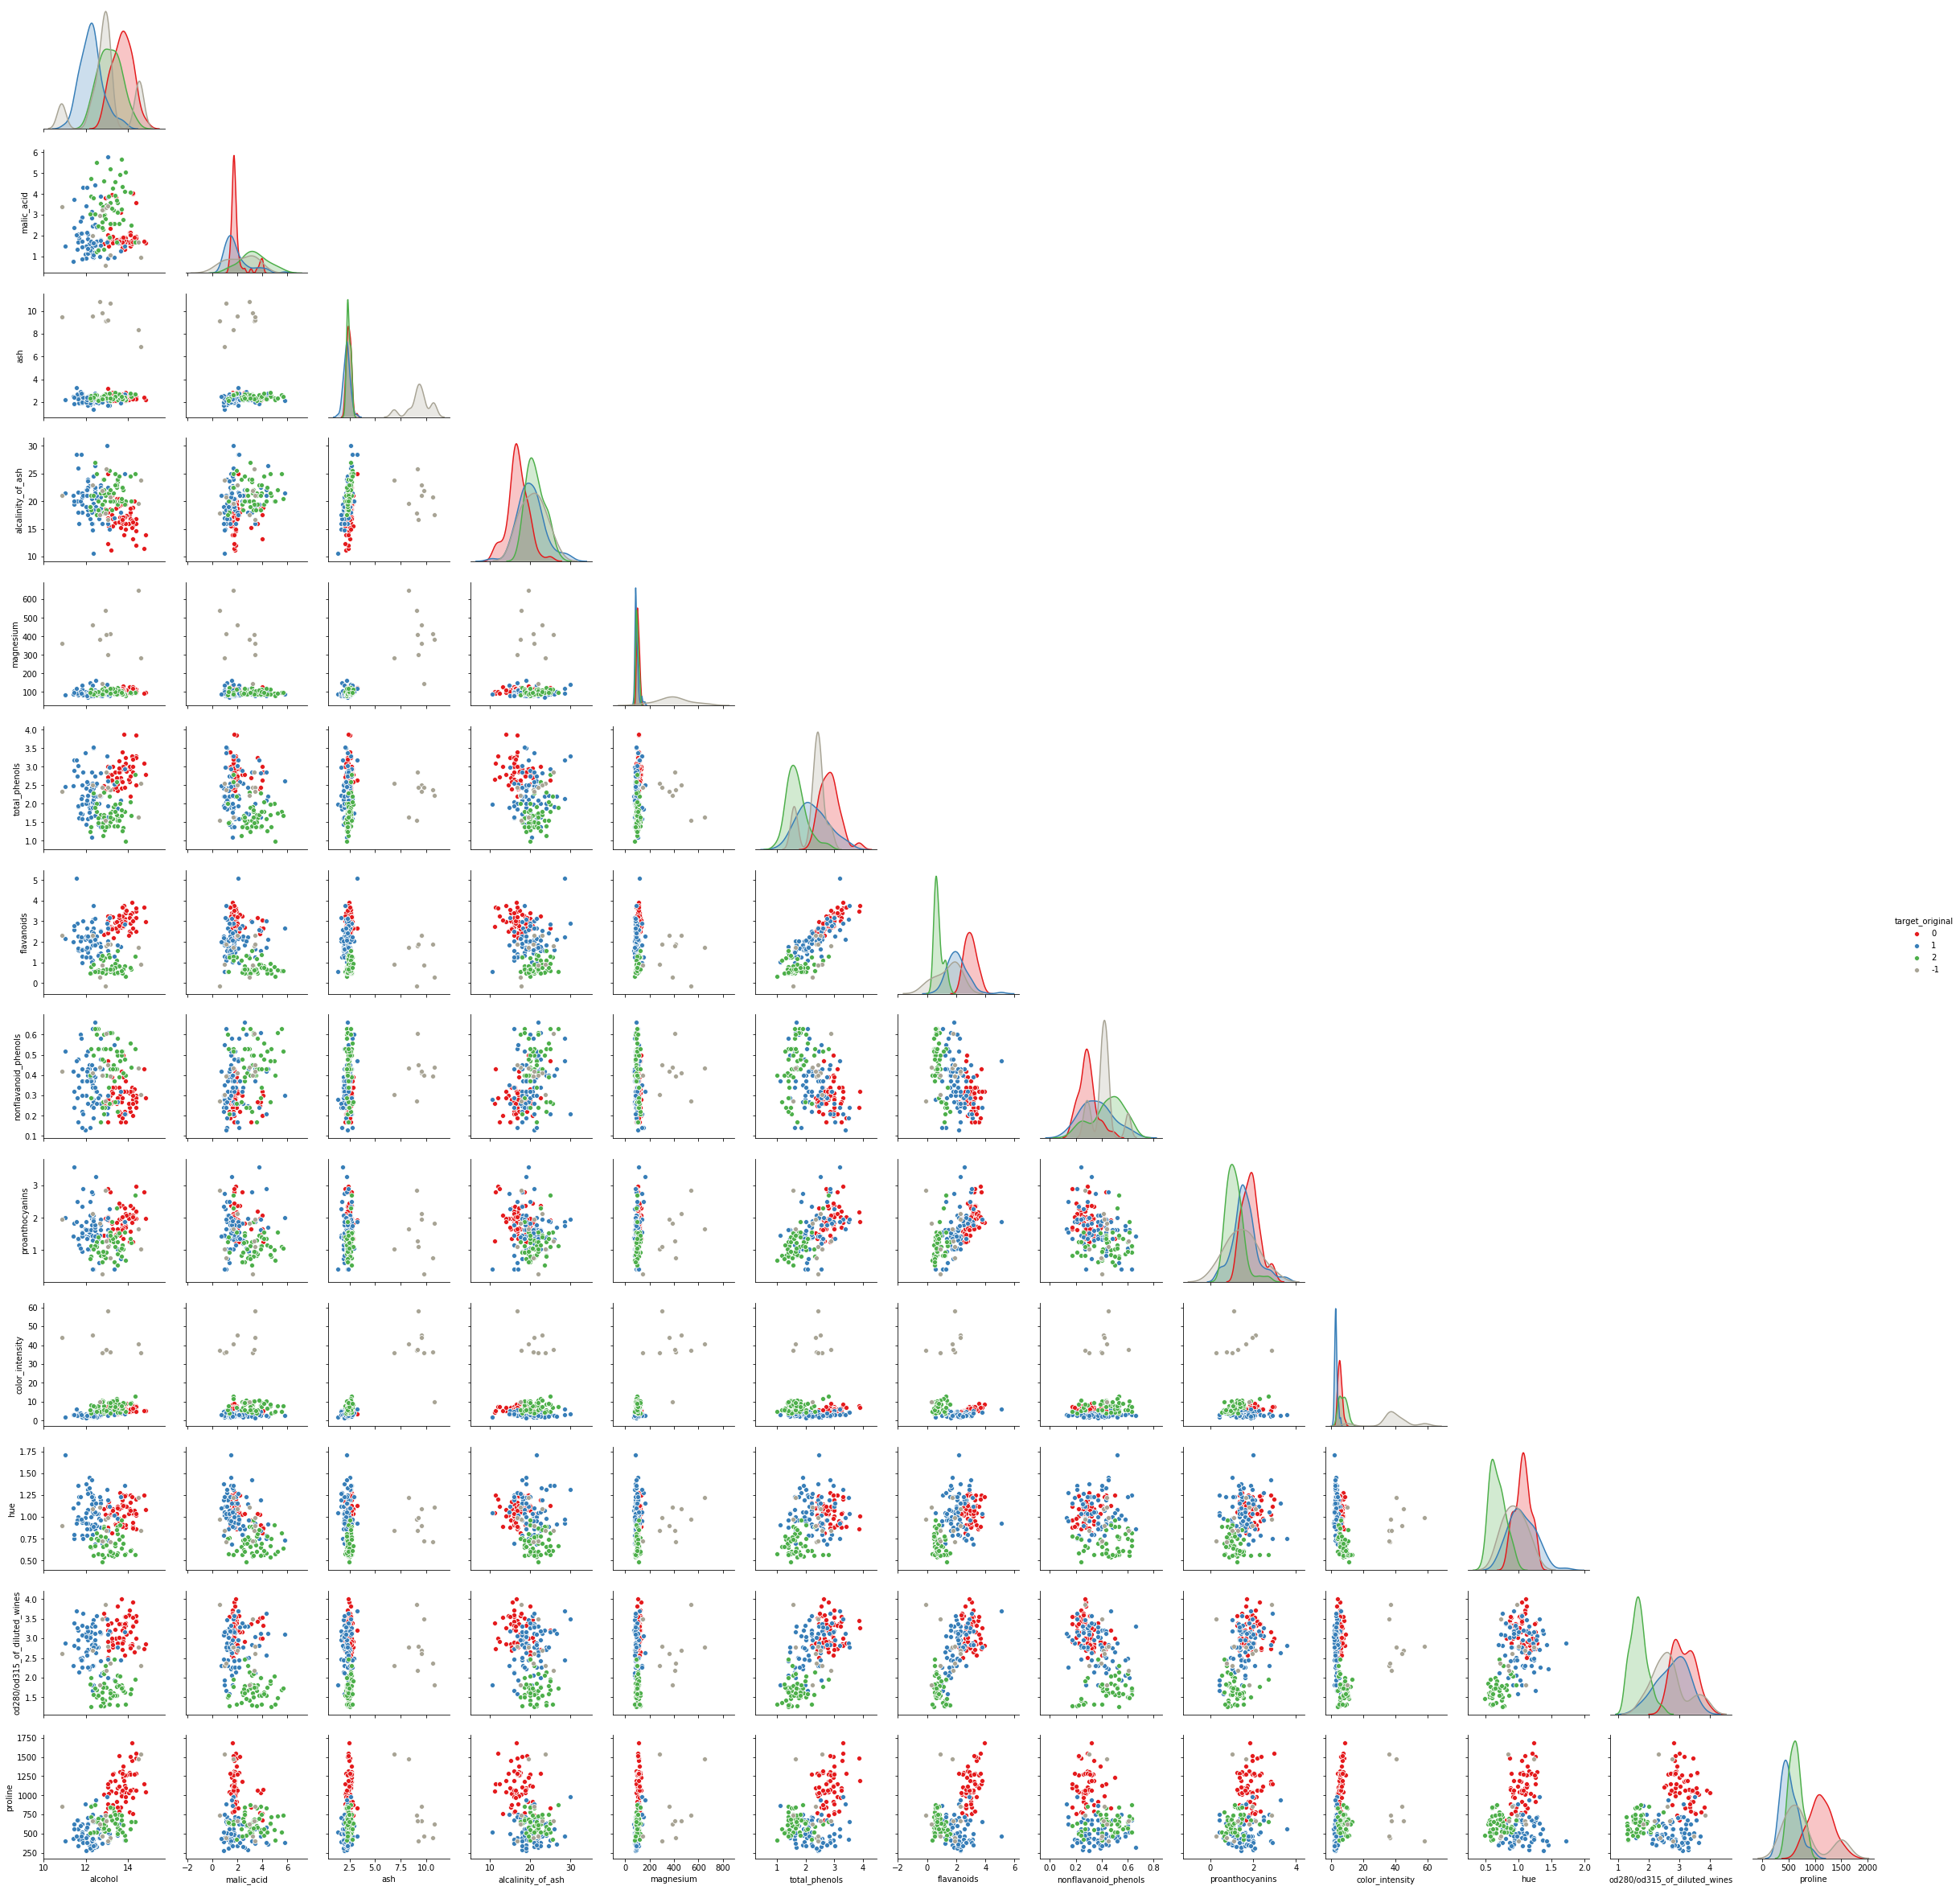

In [15]:
g = sns.pairplot(data=df_wine_new, vars=df_features.columns, hue='target_original',
                 corner=True, palette=customer_palette, hue_order=target_order)

The reader must have guessed which are the chosen three ;P.

In [16]:
X_train_o = df_wine_new.iloc[:,:-4].copy()
y_train_o = df_wine_new.iloc[:,-4:].copy()

X_trans_dict_o, X_pca_dict_o = transformer_bundle(X_train_o)

C:\Users\kefei\Anaconda3\envs\blog\lib\site-packages\sklearn\preprocessing\_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (188). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


Let's plot the covariance matices. 

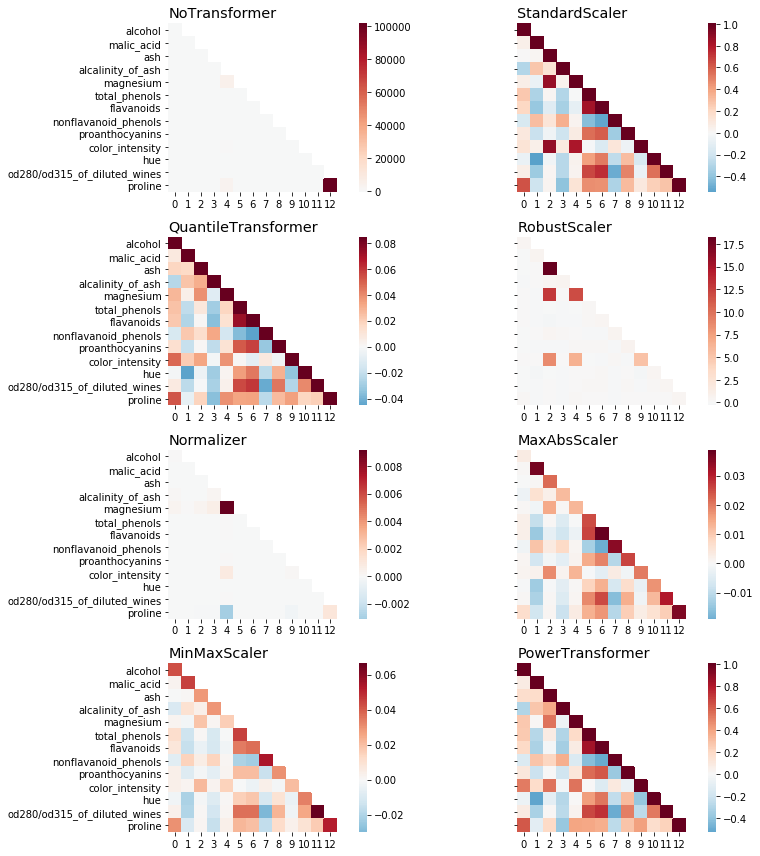

In [17]:
trans_heat_plot(X_trans_dict_o, y_axis_labels=df_features.columns)

We invite the reader to pay particular attention to the robust scaler: note that the color bar of the heatmap goes up to 17.5 as the maximum value, and the three chosen variables to which outliers are added pop out from the plot, overwhelming the rest of the variables. This is because the robust scaler takes the middle 50% part of each variable (1st to 3rd quartile) to calculate the variance and center the values by the median. 

Though being a linear scaler like the standard scaler, it rules out the effect of outliers thus keeps the structure of the "normal" part of the data and emphasizes the outliers, hence the huge variance of the three perturbed variables. The rest of the heatmap is seemingly plain, which shows that the scaler keeps all variables' non-outlier information at a similar scale, despite the outliers.

Its standard scaler cousin, on the other hand, almost smashes the variance of the three chosen columns' non-outlier values, making the informative part of the three unusable compared to the others. PCA will be cheated by such transformation and put wrong amount of attention to the three variables (theoretically, more than it should be).

## 1. Bring on the tasks

Let's visualize the first 2 principal components from each scaler.

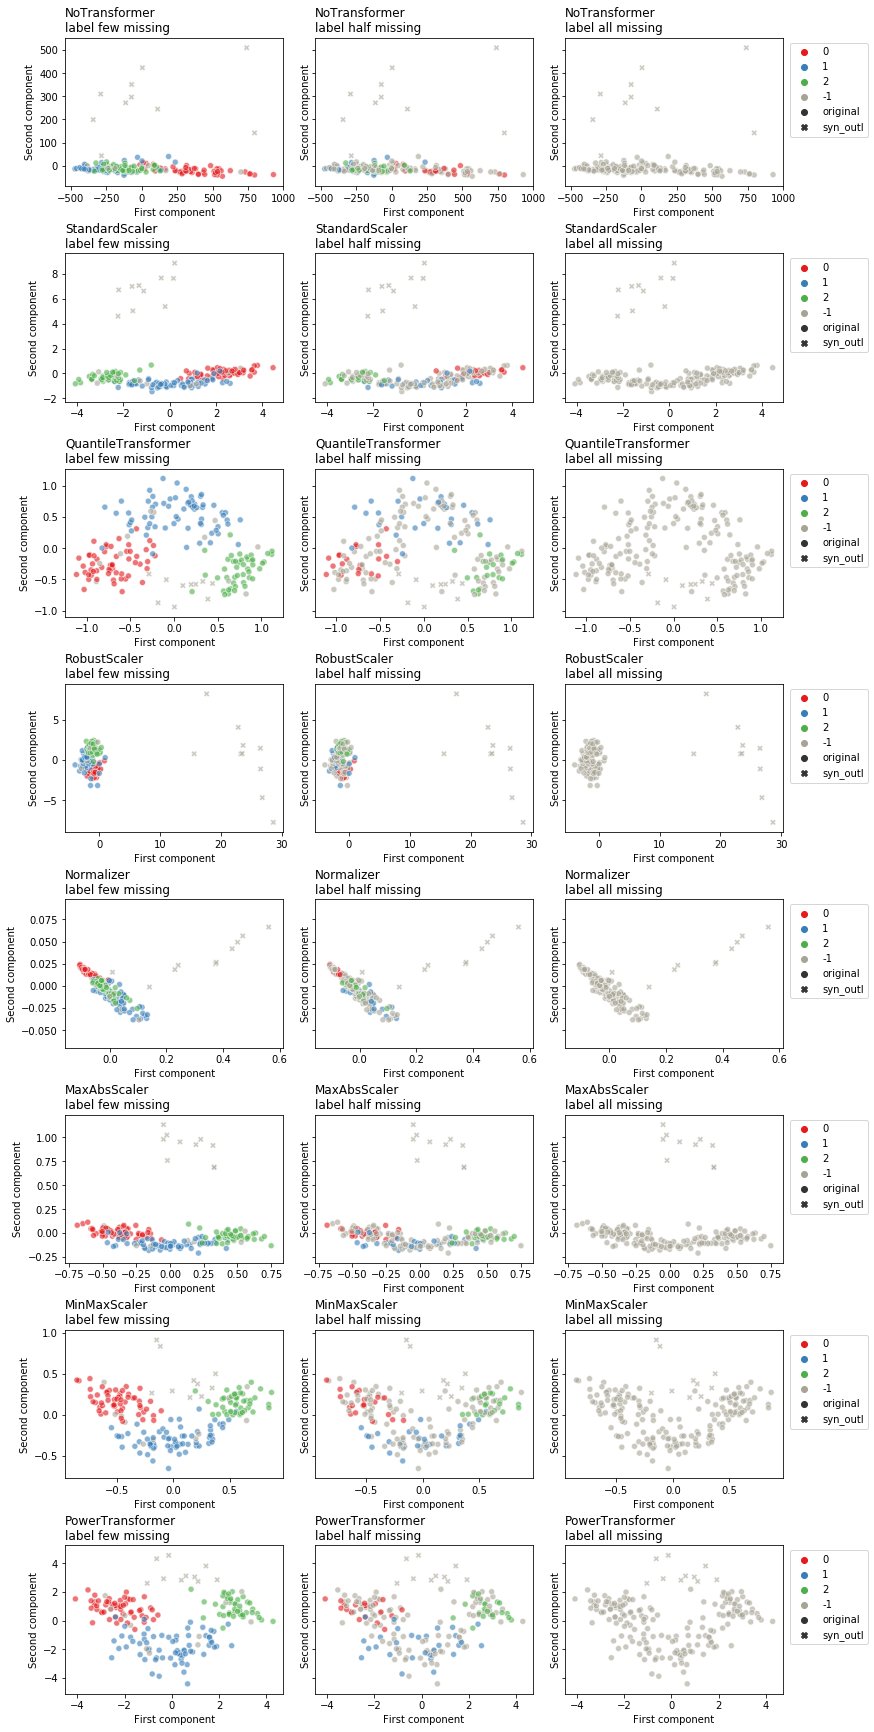

In [18]:
pca_scatter_plot(X_pca_dict_o, y_train_o.iloc[:,1:], highlight_list=np.arange(-10,0))

When outliers are introduced into the dataset, the performance of different transformers is very interesting. 

Under the multi-class classification circumstance, we would like that the result to be less influenced by the outliers, i.e., the outliers don't form a new class independent of the existing three and blend "naturally" into the classes. Two transformers pass this test: the quantile transformer and the min-max transformer. 

On the contrary, if we are to do some kind of anomaly detection (say for example the aim is to identify the unqualified wine), which is a branch of unsupervised learning, we will prefer the transformers who make the outliers stand out even more dramatically, like the standard scaler and the robust scaler. 

Note that this is not a general conclusion, for what we've done is quite limited, we did not cover other possible ways of synthesising outliers. What we can safely suggest is to test a whole bunch of transformers (linear or not) and find the one that fits better the problem.

In the following part, we visualise the augmented dataset using both true labels and K-means clustering labels.

First, let's think of it a classification problem, as it originally is.

In [19]:
# kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE)

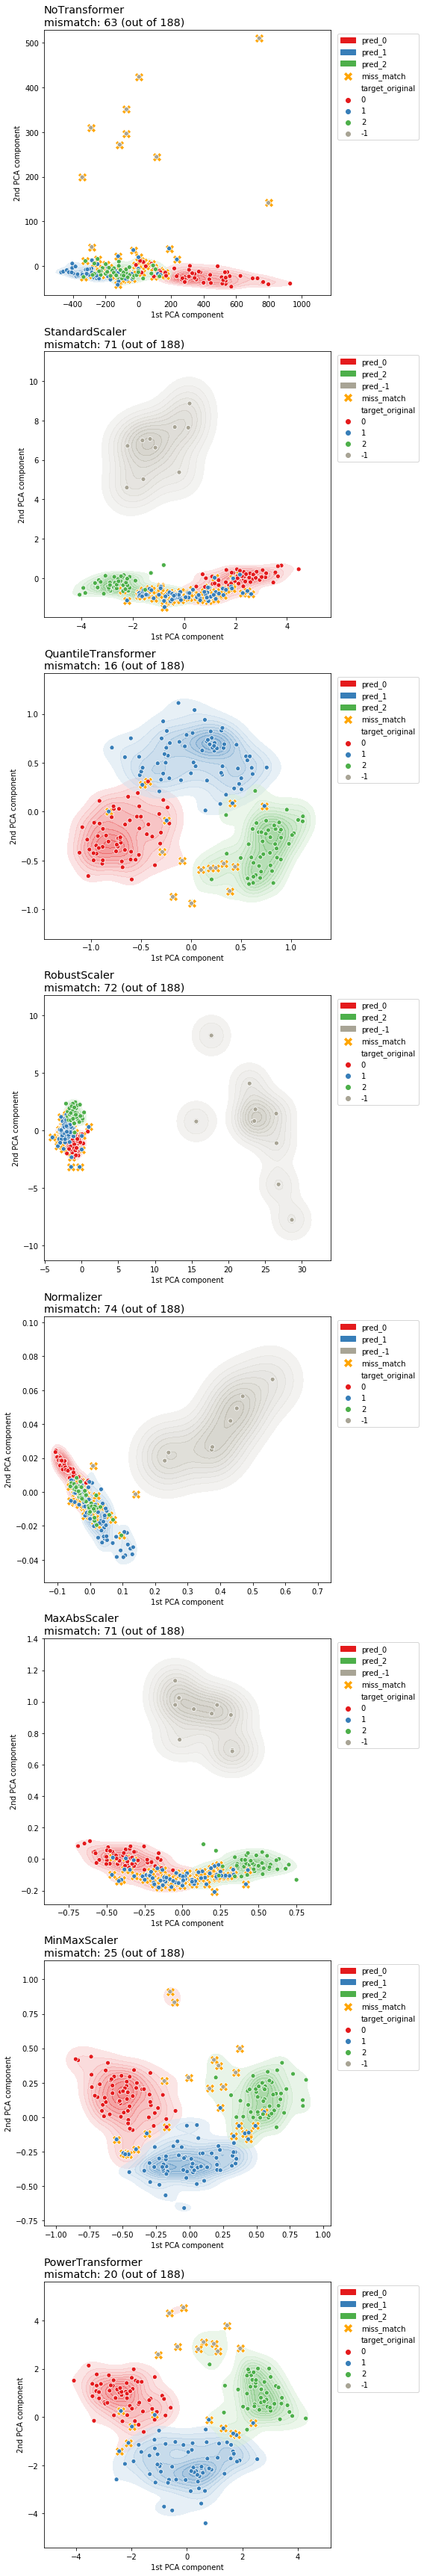

In [20]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE)
pca_cluster_contour_plot(X_pca_dict_o, y_train_o, kmeans)

The contours are the territories of each cluster and the colored dots are data points with their real label.

Almost all linear transformers result in a "bad" outcome: the real data points are squeezed too much by the outliers that the K-means could not even find 3 clusters, instead it returns only 2. In this test, we might prefer quantile transformer, power transformer and minmax transformer than others.

Now, let's consider an anomaly detection problem. Normally we do not solve such detection tasks with K-means, instead we may use DBSCAN, isolated forest or other algorithms that detect noises in a dataset. But since we know *a priori* that there are 3 classes, in this case outliers may be detected by incrementing the K value in K-means. Below are the same plots but with K=4.

**Remark:** It's worth to mention that, since we generated the outliers by pushing further the maximum value of some variables, the outliers will form a group on one single side of the original data, as shown in the previous figures. Nevertheless, if we change our way of synthesising data from monotone to multi-direction, which is to say making some minimum values even smaller as well, we will see outliers spattering all over the feature space. In such case, K-means no longer suits for we don't know how many groups the outliers will form.

In [21]:
# pca_cluster_contour_plot({key:X_pca_dict_o[key] for key in list(X_pca_dict_o.keys())[-2:]},
#                          y_train_o, kmeans)

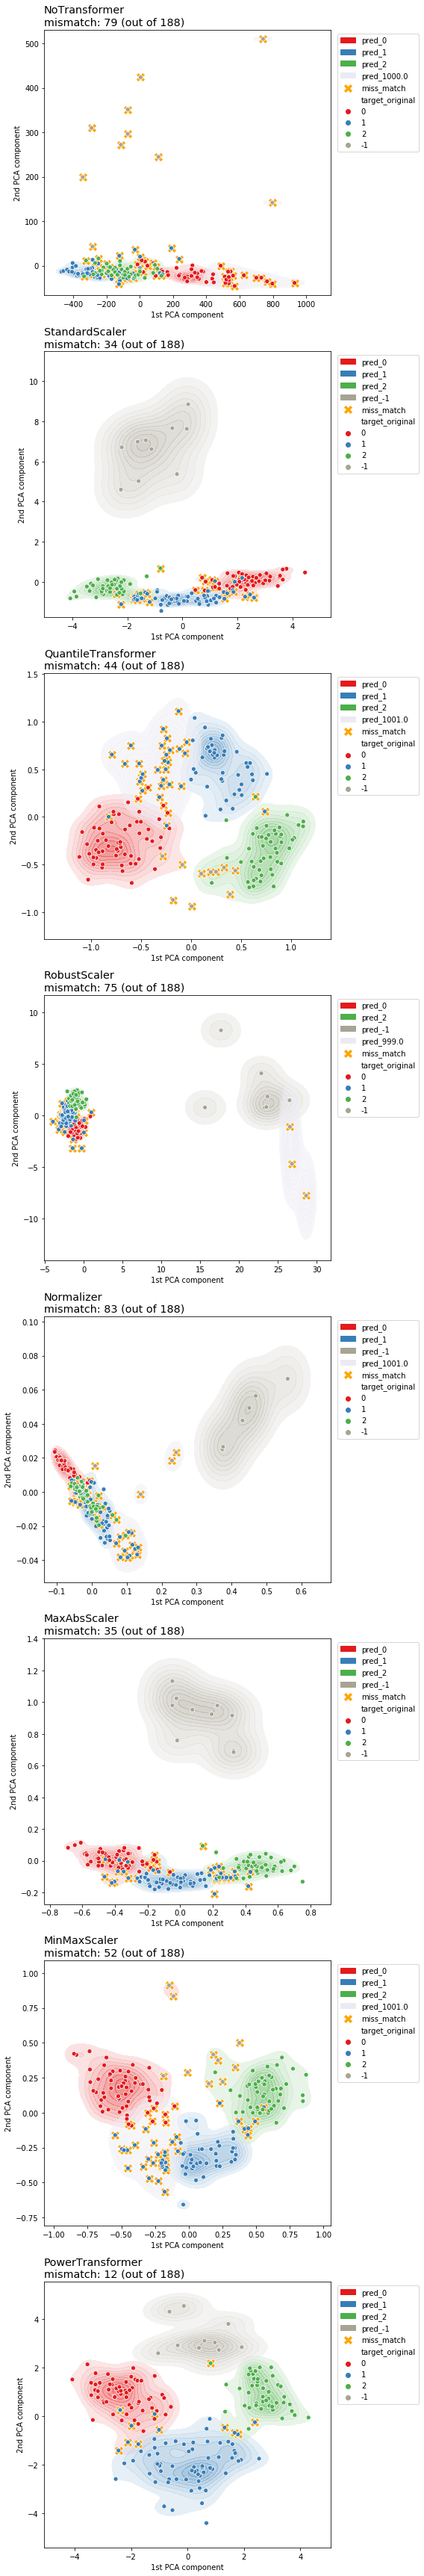

In [22]:
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
pca_cluster_contour_plot(X_pca_dict_o, y_train_o, kmeans)

With the outliers detection aim, we would prefer different scalers than just now: standard scaler, max-abs scaler, and power transformer (even normaliser is not so bad ;)).

## 2. Summary of this section

We've tested our scalers using synthetic outliers, the way each scaler reacts to outliers is quite varied. It would be more cautious to judge the performance of each scaler according to the task you are having.

Next time, we will move on to test the limit of PCA, see how it reacts to the categorical data.